## Perceptual decision making

### 1. Data generation
$u(t)= \bigg\{ \begin{array}{ll} \bar{u} + \xi (t) & \text{if } 5 \leq t \leq 45 \\  \xi (t) & otherwise \end{array}$

$\bar{u}$ stimulus strength, drawn from a uniformormly from $\pm \frac{3.2}{100} \{1,2,4,8,16\}$ 

$\xi (t)$ is background noise, drawn from a normal distribution with mean 0 and standard deviation 0.03. 

resample for each trial. noise resampled for each time step. 

target $y$ is $sgn(\bar{u})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# #%matplotlib inline

In [6]:
# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


In [2]:
class DecisionDataset(Dataset):
    def __init__(self, n_trials, n_time_step=75):   
        """
        Generate perceptual decision-making data.

        Parameters
        ----------
        n_trials : int
            Number of trials.
        n_time_step : int (Default: 75)
            Number of time steps.
        Returns
        -------
        u : array, shape (n_trials,n_time_step)
            input 
        y : array, shape (n_trials,n_time_step)
            output 
        """
        strength_choices = (3.2/ 100)  * np.array([1,2,4,8,16, -1,-2,-4,-8,-16])
        n_time_step = 75
        time_step= 20 #ms

        u = np.zeros([n_trials,n_time_step])
        y = np.zeros([n_trials,n_time_step])

        for trial in range(n_trials):
            strength = np.random.choice(strength_choices)

            for t in range(0,n_time_step):
                if t>=5 and t<=45:
                    #noise with std 0.03
                    u[trial,t] = strength + np.random.normal(0,0.03)
                else:
                    u[trial, t] = np.random.normal(0,0.03)

                y[trial, t] = np.sign(strength)
        
        self.u = torch.tensor(u, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.n_trials = n_trials
        
    def __len__(self):
        return self.n_trials
    
    def __getitem__(self, idx):
        return self.u[idx,:], self.y[idx,:]

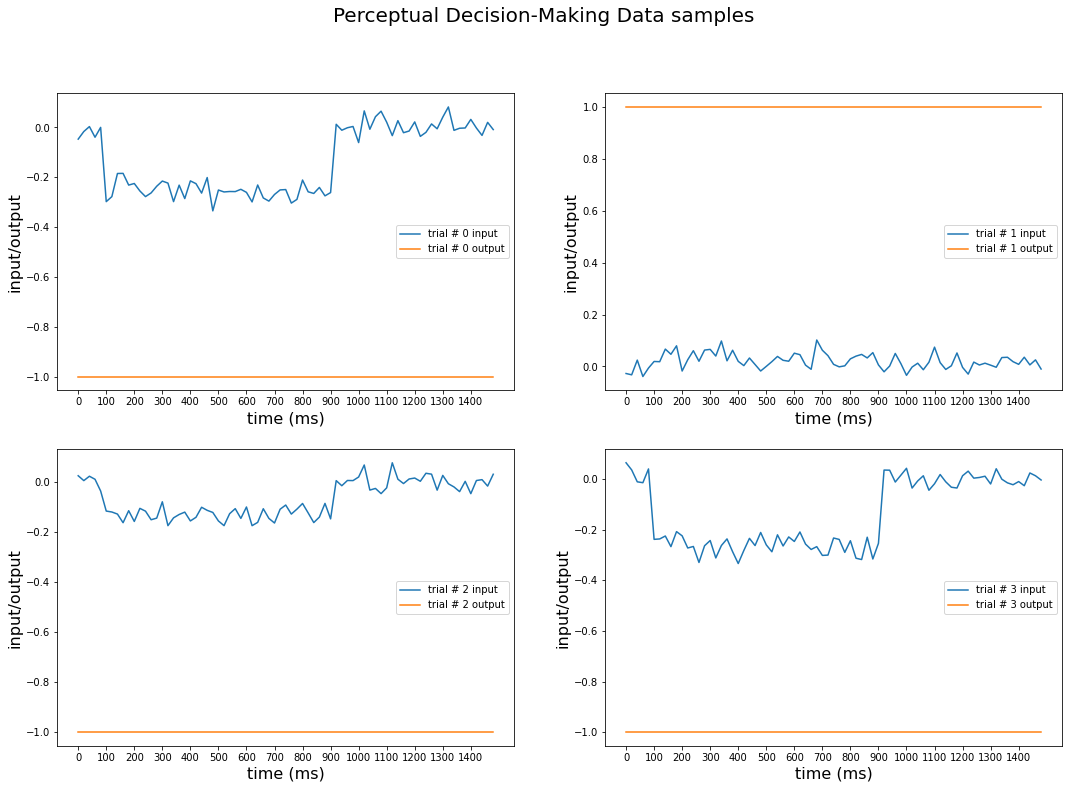

In [7]:
d_data = DecisionDataset(1000)
d_dataloader = DataLoader(d_data, batch_size=32)

u_arr, y_arr = next(iter(d_dataloader))

plt.figure(figsize=(18,12))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.plot(u_arr[idx,:], label='trial # {} input'.format(idx))
    plt.plot(y_arr[idx,:], label='trial # {} output'.format(idx))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20msb
    plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()

### 2. Recurrent neural network
one dimensional input and output, 

N units in the hidden layer, 

left and right connectivity vector $m, n$ trainable parameters, 

fixed input and output weights $I, W$. 

trainable and fixed weights are drawn from standard normal distribution. 

$\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t)$ 

$\phi(x) = \tanh$ 

$\tau = 100 ms$ 
 
$\Delta t = 20 ms$ 

$J = \frac{1}{N} mn^T$ 

Using forward Euler method to solve the differential equation. 

$x_i(t+ \Delta t) = x_i(t) + \frac{1}{\tau}  \Delta t  \bigg( -x_i(t) + \sum_{j=1}^N J_{ij} \phi(x_j(t)) + I_i u(t) \bigg)$ 



In [3]:
import torch
import torch.nn

class RNN(nn.Module):
    
    def __init__(self, network_size=128):
        
        super(RNN, self).__init__()
        self.network_size = network_size
        
        # Weight initialization
        #unit rank rnn weight matrix J=mn^T/n
        self.m = nn.Parameter(torch.rand(self.network_size))
        self.n = nn.Parameter(torch.rand(self.network_size))

        self.I = torch.randn(self.network_size)
        self.w = torch.randn(self.network_size)*4
        
                # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()
        
        with torch.no_grad():
            self.m.normal_(std=1)
            self.n.normal_(std=1)

    def forward(self, u):
        x = torch.randn(u.size(0), self.network_size)
        z = torch.zeros(u.shape)
        #unit rank rnn weight matrix J=mn^T/n
        J = torch.matmul(self.m[:,None], self.n[None,:]) / self.network_size
        
        for i in range(u.size(1)):
            delta_x = (
                -x 
                + torch.matmul(self.activation(x), J) 
                + torch.matmul(u[:,i,None], self.I[None,:])
            ) * (self.dt / self.tau)
            
            x = x + delta_x
            
            output = torch.matmul(self.activation(x), self.w) / self.network_size            
            z[:, i] = output    
            
        return z

### 3. Training
train a network of size $N=128$. batch size 32 trals. and specific lost function is defined as the mean squared error of last $T=15$ time step of each trial:

$loss = \frac{1}{32 * 15} \sum_{i=1}^{32} \sum_{t=45}^{60} (z_i(t) - y_i(t))^2$ 

learning rate $0.05$ , Adam optimizer.

In [4]:
# Training function slightly modified from PyTorch quickstart tutorial
def train(dataloader, model, loss_fn, optimizer, T=15):
    size = len(dataloader.dataset)
    optimizer.zero_grad()
    model.train(True)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # print("pred shape: ", pred.shape)
        loss = loss_fn(pred[:,-T:], y[:,-T:])

        # print(pred[0, :])
        # print(pred[0, -T:])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
# Overfitting sanity check
d_dataset = DecisionDataset(32000)
train_dataloader = DataLoader(d_dataset, batch_size=32)

learning_rate = 5e-3
T=15
model = RNN(128)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train(train_dataloader, model, loss_fn, optimizer, T=T)

loss: 0.997621  [   32/32000]
loss: 0.448371  [ 3232/32000]
loss: 0.039970  [ 6432/32000]
loss: 0.020625  [ 9632/32000]
loss: 0.032162  [12832/32000]
loss: 0.022135  [16032/32000]
loss: 0.078091  [19232/32000]
loss: 0.014822  [22432/32000]
loss: 0.021560  [25632/32000]
loss: 0.020898  [28832/32000]


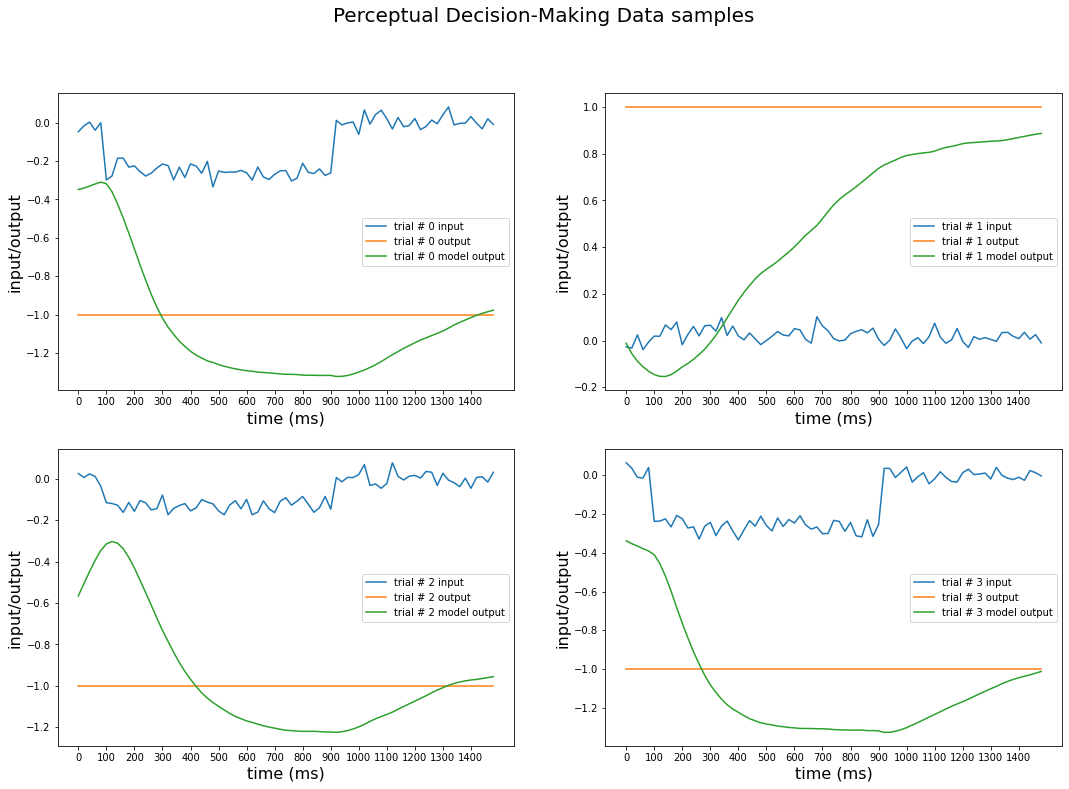

In [9]:

u_arr, y_arr = next(iter(d_dataloader))

plt.figure(figsize=(18,12))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.plot(u_arr[idx,:], label='trial # {} input'.format(idx))
    plt.plot(y_arr[idx,:], label='trial # {} output'.format(idx))
    plt.plot(model(u_arr[idx,:].unsqueeze(0)).detach().numpy().squeeze(), label='trial # {} model output'.format(idx))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20msb
    plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()

Text(0, 0.5, 'n')

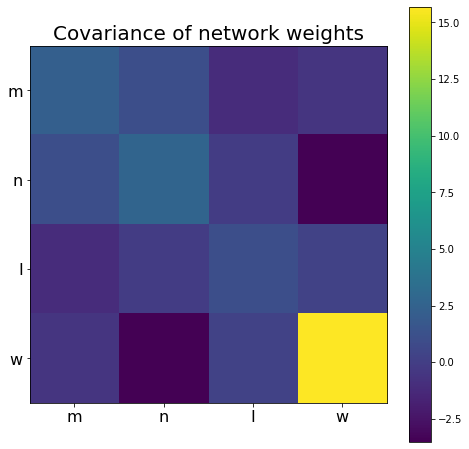

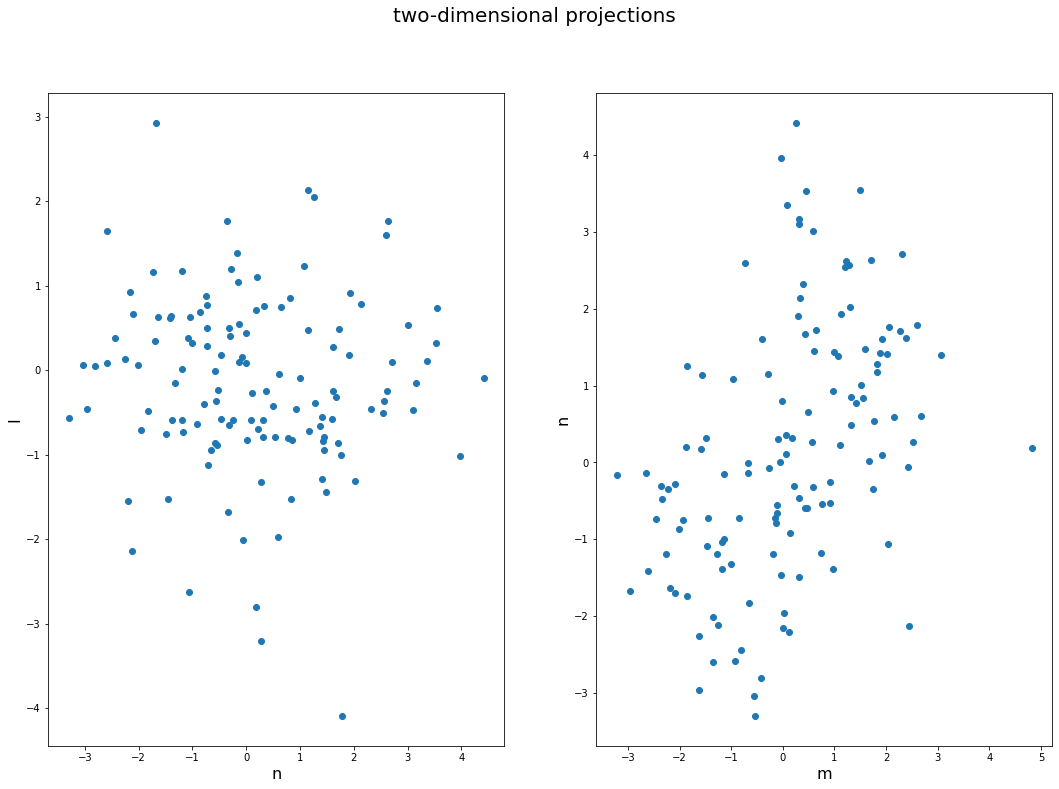

In [19]:
m=model.m.detach().numpy()
n=model.n.detach().numpy()
I=model.I.detach().numpy()
w=model.w.detach().numpy()

net=np.stack([m,n,I,w], axis=0)
cov=np.cov(net)
plt.figure(figsize=(8,8))
plt.imshow(cov)
plt.colorbar()
plt.title('Covariance of network weights', fontsize=20)
plt.xticks(np.arange(0, 4, step=1), ['m', 'n', 'I', 'w'], fontsize=16)
plt.yticks(np.arange(0, 4, step=1), ['m', 'n', 'I', 'w'], fontsize=16)


plt.figure(figsize=(18,12))
plt.suptitle('two-dimensional projections', fontsize=20)
plt.subplot(1,2,1)
plt.scatter(n, I)
plt.xlabel('n', fontsize=16)
plt.ylabel('I', fontsize=16)
plt.subplot(1,2,2)
plt.scatter(m, n)
plt.xlabel('m', fontsize=16)
plt.ylabel('n', fontsize=16)